In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
    ('orders.csv', 'orders'),
    ('payments.csv', 'payments'),
    ('products.csv', 'products'),
    ('sellers.csv', 'sellers')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='@NSUabcd1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'E:/dataset/Ecommers'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db= mysql.connector.connect(host='localhost',
                         user='root',
                         password='@NSUabcd1234',
                         database='ecommerce')   # tuple
cur=db.cursor()  # avtivating cursor under database. method is used in Python database
                 #libraries. This cursor object allows you to execute SQL queries and 
                 #interact with the database.

# List all unique cities where customers are located.


In [2]:
query = """ select distinct customer_city  from customers """

cur. execute(query)
data= cur.fetchall()
df= pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [3]:
 query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur. execute(query)
data= cur.fetchall()
"Total order placed in 2017 is ",data[0][0]

('Total order placed in 2017 is ', 135303)

#  Find the total sales per category.

In [10]:
 query = """select products.product_category category,round(sum(payments.payment_value),2) sales 
 from products join order_items on products.product_id = order_items.product_id
 join payments on payments.order_id=order_items.order_id
 group by category"""

cur. execute(query)

data = cur.fetchall()

df= pd.DataFrame(data,columns =["category","sales"])
df

,category,sales
0,perfumery,4053909.28
1,Furniture Decoration,11441411.13
2,telephony,3895056.41
3,bed table bath,13700429.37
4,automotive,6818354.65
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


# Calculate the percentage of orders that were paid in installments.

In [16]:
 query = """select ((sum(case when payment_installments >=1 then 1 else 0 end))/count(*))*100
 from payments"""

cur. execute(query)

data = cur.fetchall()

"Calculate the percentage of orders that were paid in installments",data[0][0]

('Calculate the percentage of orders that were paid in installments',
 Decimal('99.9981'))

# Count the number of customers from each state.

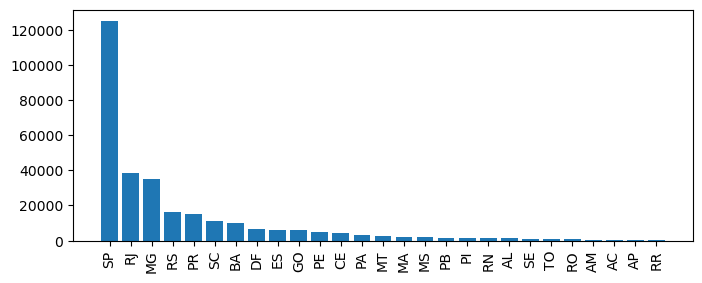

In [28]:
 query = """select customer_state, count(customer_unique_id) from customers
 group by customer_state"""

cur. execute(query)

data = cur.fetchall()
df= pd.DataFrame(data,columns = ["State","Num_of_Customers"]) #to make the table
df =df.sort_values(by = "Num_of_Customers",ascending= False) #to sort the data

plt.figure(figsize = (8,3))
plt.bar(df["State"],df["Num_of_Customers"])
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

<function matplotlib.pyplot.show(close=None, block=None)>

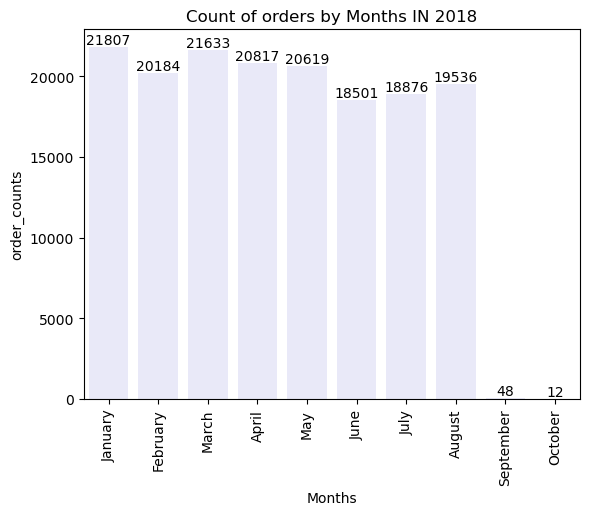

In [50]:
 query = """select monthname(order_purchase_timestamp) months,count(order_id) order_count
 from orders where year(order_purchase_timestamp)=2018
 group by months"""

cur. execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns = ["Months","order_counts"])

o= ["January","February","March","April","May","June","July","August","September","October"]

ax=sns.barplot(x = df["Months"],y= df["order_counts"], data=df,order=o,color= "lavender")

plt.title("Count of orders by Months IN 2018")
plt.xticks(rotation=90) # to give x axis names a angle
ax.bar_label(ax.containers[0]) #to give lebel in each bar
plt.show

# Find the average number of products per order, grouped by customer city.

In [58]:
 query = """with count_per_order as
 
(select orders.order_id , orders.customer_id , count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by  orders.order_id , orders.customer_id)

select customers.customer_city, avg(count_per_order.oc) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""

cur. execute(query)

data = cur.fetchall()
df= pd.DataFrame(data, columns = ["city","average_num_product_per_order"])
df.head(10)


,city,average_num_product_per_order
0,padre carvalho,42.0000
1,celso ramos,39.0000
2,datas,36.0000
3,candido godoi,36.0000
4,matias olimpio,30.0000
5,cidelandia,24.0000
6,curralinho,24.0000
7,picarra,24.0000
8,morro de sao paulo,24.0000
9,teixeira soares,24.0000


#  Calculate the percentage of total revenue contributed by each product category.

In [5]:
 query = """select products.product_category category,
((sum(payments.payment_value))/(select sum(payment_value) from payments))*100 sales 
 from products join order_items 
 on products.product_id = order_items.product_id
 join payments 
 on payments.order_id=order_items.order_id
 group by category order by sales desc"""

cur. execute(query)

data = cur.fetchall()

df= pd.DataFrame(data,columns =["category","percentage of total revenue"])
df.head(10)

,category,percentage of total revenue
0,bed table bath,42.790114
1,HEALTH BEAUTY,41.411365
2,computer accessories,39.611296
3,Furniture Decoration,35.734595
4,Watches present,35.710615
5,sport leisure,34.783901
6,housewares,27.353785
7,automotive,21.295550
8,Garden tools,20.945404
9,Cool Stuff,19.481647


# Identify the correlation between product price and the number of times a product has been purchased.

In [14]:
import numpy as np
query="""select  products.product_category, order_items.product_id, order_items.order_item_id, order_items.price,
count(order_items.order_id) 
as Number_of_purchase
from order_items join products
on order_items.product_id = products.product_id
group by products.product_category,order_items.product_id,order_items.order_item_id,order_items.price
order by Number_of_purchase desc"""

cur. execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns =["category","Product_id","Order item number","Number of times of purchase","Prices"])
#df.head(10)

arr1 =df["Number of times of purchase"]
arr2 =df["Prices"]

np.corrcoef([arr1,arr2]) 

array([[ 1.        , -0.02804575],
       [-0.02804575,  1.        ]])